In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import csv
import pandas as pd
import numpy as np
import scipy.io as sio

data = pd.read_csv('data_for_student_case-2.csv')

In [2]:
## check how many kinds of currency are there?
currencylist = data['currencycode'].unique()
print(currencylist)


['MXN' 'AUD' 'NZD' 'GBP' 'SEK']


In [3]:
def perday(df,DateName):

     df[DateName]=pd.to_datetime(df[DateName])
     df=df.sort_values(by=DateName)
     df[DateName]=df[DateName].dt.date
     return df

In [4]:
## currency convert from amount to amountEUR

#cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
#cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked  

def transf(df):
    currencyconvert = {"AUD":0.680237,"MXN":0.0487438,"NZD":0.630313,"GBP":1.18285,"SEK":0.103558}
    amountEUR = []
    for i in df.index:
        if df['currencycode'][i] == "MXN":
            amountEUR.append(currencyconvert["MXN"]*df['amount'][i])
#         print(datacharge.loc[i,['currencycode']])
        if df['currencycode'][i] == "AUD":
            amountEUR.append(currencyconvert["AUD"]*df['amount'][i])

        if df['currencycode'][i] == "NZD":
            amountEUR.append(currencyconvert["NZD"]*df['amount'][i])

        if df['currencycode'][i] == "GBP":
            amountEUR.append(currencyconvert["GBP"]*df['amount'][i])

        if df['currencycode'][i] == "SEK":
            amountEUR.append(currencyconvert["SEK"]*df['amount'][i])
            
#add a new column 'amountEUR' and choose four columns as features, leave out all transactions of "Refused"
    df['amountEUR']=amountEUR
    df=df.loc[:,['amountEUR','bookingdate','simple_journal','cardverificationcodesupplied','cvcresponsecode']]
    dfcs=df[(df['simple_journal']=='Chargeback') | (df['simple_journal']=='Settled')]


#from datetime to date difference
    dfcs=perday(dfcs,'bookingdate')
    firstday=dfcs.loc[17903,'bookingdate']
    dfcs['bookingdate'] = dfcs['bookingdate']-firstday
    dfcs['bookingdate']=dfcs['bookingdate'] / np.timedelta64(1, 'D')

    dfcs.loc[dfcs['cardverificationcodesupplied']==False,'cardverificationcodesupplied']=0.0
    dfcs.loc[dfcs['cardverificationcodesupplied']==True,'cardverificationcodesupplied']=1.0
    dfcs=dfcs[(dfcs['cardverificationcodesupplied']==0) | (dfcs['cardverificationcodesupplied']==1)]
    dfcs.loc[:,'cardverificationcodesupplied']=pd.to_numeric(dfcs.loc[:,'cardverificationcodesupplied'])
    
    dfcs.loc[dfcs['simple_journal']=='Chargeback','simple_journal']=1.0
    dfcs.loc[dfcs['simple_journal']=='Settled','simple_journal']=0.0
    dfcs.loc[:,'simple_journal']=pd.to_numeric(dfcs.loc[:,'simple_journal'])

    dfcs.loc[:,'cvcresponsecode']=pd.to_numeric(dfcs.loc[:,'cvcresponsecode'])
    
    


    return dfcs

In [5]:
## preprocessing the data, aggregate by day and currency convert,  
## transfer the data structure to numeric, and select the relevant features prepare for classificaiton
dfcs=transf(data)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
## check the data type 
dfcs.dtypes

amountEUR                       float64
bookingdate                     float64
simple_journal                  float64
cardverificationcodesupplied    float64
cvcresponsecode                   int64
dtype: object

In [7]:
##-----seperate the data to features and labels
dffeatures = dfcs[['amountEUR','bookingdate','cardverificationcodesupplied','cvcresponsecode']]
labels = dfcs['simple_journal']


TP: 20
FP: 0
FN: 60
TN: 44689
Original dataset shape Counter({0.0: 178808, 1.0: 265})
Resampled dataset shape Counter({0.0: 178808, 1.0: 178808})
TPSM: 61
FPSM: 366
FNSM: 19
TNSM: 44323


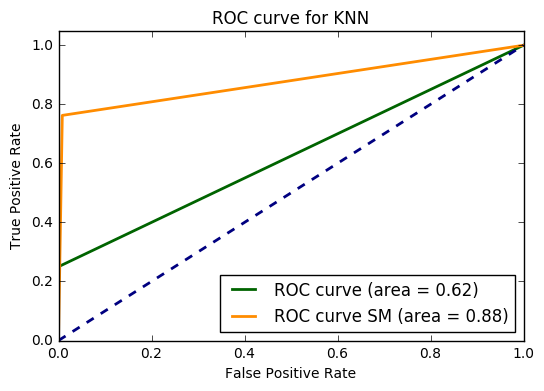

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from collections import Counter
from imblearn.over_sampling import     SMOTE 


def classify(dffeatures,labels):
    TP, FP, FN, TN = 0, 0, 0, 0
    TPSM, FPSM, FNSM, TNSM = 0, 0, 0, 0
    x_array = np.array(dffeatures)
    y_array = np.array(labels)
    usx = x_array
    usy = y_array
    x_train, x_test, y_train, y_test = train_test_split(usx, usy, test_size = 0.2)#test_size: proportion of train/test data
  
##-----UNSMOTED---------##

# #--- classifier 1:  KNN ----------------#
    clf = neighbors.KNeighborsClassifier(n_neighbors=3)
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)




# #---classifier 2: Linear Regression-------#
    # Create linear regression object
#     regr = linear_model.LinearRegression()

    # Train the model using the training sets
#     regr.fit(x_train, y_train)
#     y_predict = regr.predict(x_test)
#     print(y_predict)

#-------apply the threshold to classify the score to 2 classes (1/0)
#     for j in range(len(y_predict)) :
#         if y_predict[j] < 0.02:
#             y_predict[j]=0
#         else:
#             y_predict[j]=1
#     print(y_predict)
#------------END of LR---------



    for i in range(len(y_predict)):
        if y_test[i]==1 and y_predict[i]==1:
            TP += 1
        if y_test[i]==0 and y_predict[i]==1:
            FP += 1
        if y_test[i]==1 and y_predict[i]==0:
            FN += 1
        if y_test[i]==0 and y_predict[i]==0:
            TN += 1
    print ('TP: '+ str(TP))
    print ('FP: '+ str(FP))
    print ('FN: '+ str(FN))
    print ('TN: '+ str(TN))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
    roc_auc = auc(fpr, tpr)

#----------------------------------------------------------## 
        ## -----do SMOTE on training data here---------##
    x_train, y_train = dosm(x_train, y_train)
    
    
#--- classifier 1:  KNN --------
    clfSM = neighbors.KNeighborsClassifier(n_neighbors=3)
    clfSM.fit(x_train, y_train)
    y_predictSM = clfSM.predict(x_test)
#------classifer 2: Linear Regression--------
#     regrSM = linear_model.LinearRegression()

    # Train the model using the training sets
#     regrSM.fit(x_train, y_train)
#     y_predictSM = regrSM.predict(x_test)
# #     print(y_predict)

#-------apply the threshold to classify the score to 2 classes (1/0)
#     for j in range(len(y_predictSM)) :
#         if y_predictSM[j] < 0.8:
#             y_predictSM[j]=0
#         else:
#             y_predictSM[j]=1
#     print(y_predict)
#------------END of LR---------

    for i in range(len(y_predictSM)):
        if y_test[i]==1 and y_predictSM[i]==1:
            TPSM += 1
        if y_test[i]==0 and y_predictSM[i]==1:
            FPSM += 1
        if y_test[i]==1 and y_predictSM[i]==0:
            FNSM += 1
        if y_test[i]==0 and y_predictSM[i]==0:
            TNSM += 1
    print ('TPSM: '+ str(TPSM))
    print ('FPSM: '+ str(FPSM))
    print ('FNSM: '+ str(FNSM))
    print ('TNSM: '+ str(TNSM))
    fprSM, tprSM, thresholdsSM = metrics.roc_curve(y_test, y_predictSM)
    roc_aucSM = auc(fprSM, tprSM)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkgreen',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fprSM, tprSM, color='darkorange',
             lw=lw, label='ROC curve SM (area = %0.2f)' % roc_aucSM)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for KNN')
    plt.legend(loc="lower right")
    plt.savefig('ROC-KNN', ext='png', dpi=150)
    plt.show()
    
    return

def dosm(x_train, y_train):
    print('Original dataset shape {}'.format(Counter(y_train)))
    sm = SMOTE()
    X_res, y_res = sm.fit_sample(x_train, y_train)
    print('Resampled dataset shape {}'.format(Counter(y_res)))
    x_train = X_res
    y_train = y_res
    return x_train, y_train

classify(dffeatures,labels)

# print (confusion_matrix(y_test, answear))
#watch out the element in confusion matrix
# precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
# predict_proba = clf.predict_proba(x_test)#the probability of each smple labelled to positive or negative

